<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/dayflower_stomata_quantification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepStomata: マルバツユクサ気孔開度測定

deepStomata（20xx版を簡略実装したもの）による

In [1]:
!pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import dlib
import onnxruntime
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort

In [26]:
def detection(model, image, det_width):
    height, width, _ = image.shape

    ratio = width / det_width
    height_det = int(round(height / ratio))
    width_det = int(round(width / ratio))
    scaled_image = cv2.resize(image, dsize=(width_det, height_det))
    _dets = detector(scaled_image)

    dets = []
    # scale back
    for _d in _dets:
        # xmin, ymin, xmax, ymax
        r = [_d.left(), _d.top(), _d.right(), _d.bottom()]
        r = [int(x * ratio) for x in r]
        dets.append(r)
    return dets

def image_whitening(img):
    img = img.astype(np.float32)
    d, w, h = img.shape
    num_pixels = d * w * h
    mean = img.mean()
    variance = np.mean(np.square(img)) - np.square(mean)
    stddev = np.sqrt(variance)
    min_stddev = 1.0 / np.sqrt(num_pixels)
    scale = stddev if stddev > min_stddev else min_stddev
    img -= mean
    img /= scale
    return img

In [27]:
image_dir = "/content/drive/MyDrive/phenotyping_temp_assets/examples"
image_files = os.listdir(image_dir)

detector_path = "/content/drive/MyDrive/phenotyping_temp_assets/leafdisk161002_c_7.0.svm"
classifier_path = "/content/drive/MyDrive/phenotyping_temp_assets/dscnn.onnx"

In [28]:
# dlibによる気孔検出器の読み込み
detector = dlib.simple_object_detector(detector_path)

# 気孔開閉判定モデルの読み込み
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

# inputとoutputの名前を把握します。
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['input_image:0']
Output names: ['softmax_output:0']


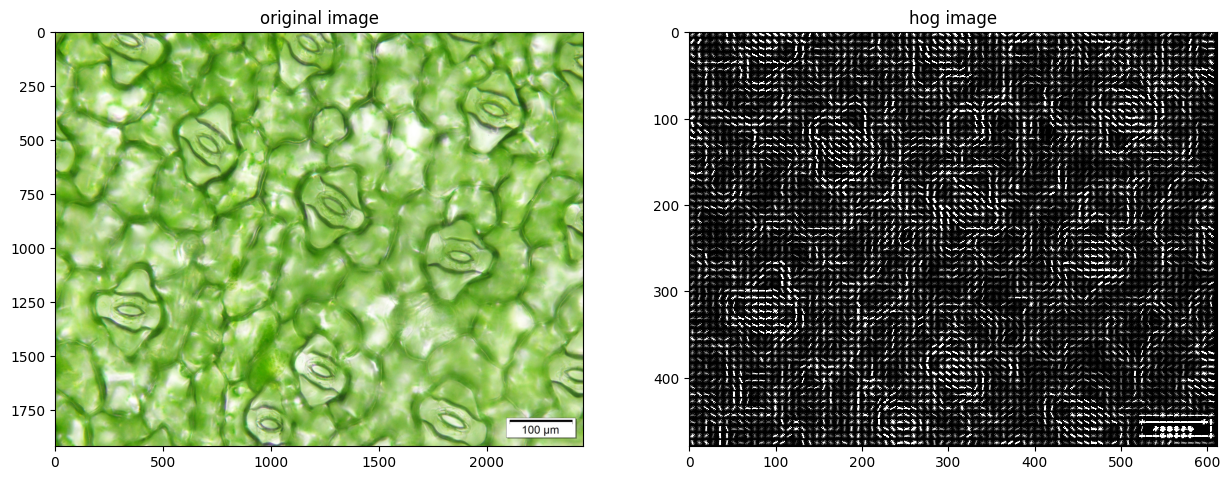

In [52]:

from skimage import feature
hog_template = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
hog_template = cv2.cvtColor(hog_template, cv2.COLOR_RGB2GRAY)
_, hog_image = feature.hog(hog_template, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),  block_norm='L2-Hys', visualize=True, transform_sqrt=True)
hog_image *= 255

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(image)
plt.subplot(1,2,2)
plt.title("hog image")
plt.imshow(hog_image, vmax=100, cmap="gray")

In [39]:
for image_file in image_files:

    path = os.path.join(image_dir, image_file)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dets = detection(detector, image, det_width=512)
    for d in dets:
        # image2 = cv2.rectangle(image2, (d[0],d[1]), (d[2],d[3]), (250, 0, 0), 10)
        stomata = image[d[1]:d[3], d[0]:d[2], :]
        stomata = cv2.resize(stomata, dsize=(56,56))
        stomata = image_whitening(stomata)
        stomata = np.expand_dims(stomata, axis=0)
        #open #closed #partially open # FP
        prediction = ort_session.run(["softmax_output:0"], {"input_image:0": stomata})[0]




    break